# Causal Inference in Marketing

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

A retail company wants to understand whether launching a new loyalty program actually causes customers to spend more, or if the increase in spending is simply correlated with other factors (like seasonality, promotions, or customer demographics).

If the company just looks at average spending of customers enrolled in the program vs. those not enrolled, they might conclude that the program works — but this difference could be misleading. For example, maybe younger, more engaged customers are more likely to join the program, and they would have spent more anyway. That’s correlation, not causation.

To make a causal inference, the analyst needs to adjust for confounding factors. One approach is to use propensity score matching: customers in the program are matched with similar customers who are not in the program (same age, income level, shopping history, etc.). If, after balancing these characteristics, program members still spend more, the company can reasonably infer that the loyalty program itself is driving the difference.

This insight is powerful for business decisions: rather than guessing, the company now has evidence that scaling the program is likely to cause an increase in revenue, not just appear to be associated with it.

In [2]:
### Causal Inference Simulation: Loyalty Program -> Spend (with confounding) ###
np.random.seed(42)  

# -----------------------------
# Simulate customer data
# -----------------------------
n = 5000

# Confounders (affect both treatment and outcome)
age = np.random.normal(40, 10, n)                              # years
income = np.random.lognormal(mean=10.2, sigma=0.35, size=n)    # annual income (skewed)
prior_spend = np.random.gamma(shape=2.0, scale=250.0, size=n)  # past 6-month spend

# True treatment effect (causal)
tau = 50.0                                 # joining the program increases spend by $50 on average

# Treatment assignment mechanism (confounded)
# More likely for younger & higher-income & high prior spend customers
linp = (
    -2.0
    - 0.03 * (age - 40)
    + 0.00003 * (income - np.median(income))
    + 0.0015 * (prior_spend - np.median(prior_spend))
)

p_treat = 1 / (1 + np.exp(-linp))          # propensity (true, unknown in practice)
T = np.random.binomial(1, p_treat, size=n) # treatment indicator (join program)

# Outcome: next 3-month spend
# Depends on confounders + treatment + noise
y = (
    200
    + 0.9 * (prior_spend ** 0.5)           # diminishing returns of prior spend
    + 0.002 * (income / 12)                # income proxy per month
    - 0.6 * np.maximum(age - 55, 0)        # older customers spend a bit less
    + tau * T                              # true treatment effect
    + np.random.normal(0, 30, n)           # idiosyncratic noise
)

df = pd.DataFrame({
    "age": age,
    "income": income,
    "prior_spend": prior_spend,
    "T": T,
    "y": y
})

# Make it real
df["age"] = df["age"].round(0).astype("Int64")
df["income"] = df["income"].round(2)
df["prior_spend"] = df["prior_spend"].round(2)
df["y"] = df["y"].round(2)

df

,age,income,prior_spend,T,y
0,45,23194.82,233.81,0,240.42
1,39,22955.32,325.64,1,262.99
2,46,14350.28,252.07,0,238.21
3,55,23967.85,453.33,0,193.25
4,38,34769.30,830.34,1,262.74
...,...,...,...,...,...
4995,40,42420.45,573.59,1,291.54
4996,47,13367.47,103.61,0,163.00
4997,71,21018.10,280.02,0,162.53
4998,48,32000.86,1171.17,0,303.75


In [3]:
### Naïve difference in means (biased if confounded) ###
naive_diff = df.loc[df["T"] == 1, "y"].mean() - df.loc[df["T"] == 0, "y"].mean()

print("== Naïve Comparison (Unadjusted) ==")
print(f"Mean(y | T=1) - Mean(y | T=0) = {naive_diff:,.2f}")
print("Note: This mixes causal effect with confounding (selection into treatment).\n")

== Naïve Comparison (Unadjusted) ==
Mean(y | T=1) - Mean(y | T=0) = 54.83
Note: This mixes causal effect with confounding (selection into treatment).



In [4]:
### Propensity Score via Logistic Regression (on observed confounders) ###
X = df[["age", "income", "prior_spend"]].copy()

# Scale features (helps logistic convergence and NN matching)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logit = LogisticRegression(max_iter=200, solver="lbfgs")
logit.fit(X_scaled, df["T"])
ps = logit.predict_proba(X_scaled)[:, 1]  # estimated propensity scores

df["ps"] = ps.clip(1e-3, 1 - 1e-3)        # avoid extreme weights exactly 0 or 1

df

,age,income,prior_spend,T,y,ps
0,45,23194.82,233.81,0,240.42,0.065892
1,39,22955.32,325.64,1,262.99,0.086823
2,46,14350.28,252.07,0,238.21,0.051600
3,55,23967.85,453.33,0,193.25,0.072931
4,38,34769.30,830.34,1,262.74,0.236958
...,...,...,...,...,...,...
4995,40,42420.45,573.59,1,291.54,0.196908
4996,47,13367.47,103.61,0,163.00,0.039009
4997,71,21018.10,280.02,0,162.53,0.034536
4998,48,32000.86,1171.17,0,303.75,0.274569


In [5]:
### IPTW (Inverse Probability of Treatment Weighting) for ATE ###
#    w_treated = 1/ps, w_control = 1/(1-ps)
w = np.where(df["T"] == 1, 1/df["ps"], 1/(1 - df["ps"]))
df["w"] = w

# Masks to avoid df.T confusion and ensure 1D numpy arrays
m1 = df["T"] == 1
m0 = ~m1

# Weighted means by group
y1_hat = np.average(df.loc[m1, "y"].to_numpy(), weights=df.loc[m1, "w"].to_numpy())
y0_hat = np.average(df.loc[m0, "y"].to_numpy(), weights=df.loc[m0, "w"].to_numpy())
ate_iptw = y1_hat - y0_hat

print("== IPTW (Propensity-Weighted) ATE Estimate ==")
print(f"Weighted Mean(y|T=1) - Weighted Mean(y|T=0) = {ate_iptw:,.2f}")

# Closer to the true causal effect (tau ≈ 50) if confounding is well-adjusted.

== IPTW (Propensity-Weighted) ATE Estimate ==
Weighted Mean(y|T=1) - Weighted Mean(y|T=0) = 49.94


In [6]:
### Covariate Balance: Standardized Mean Differences (SMD) ###
# Before vs After weighting

def smd(x_t, x_c):
    # Standardized mean difference: (mean_t - mean_c) / pooled SD
    mt, mc = x_t.mean(), x_c.mean()
    st, sc = x_t.std(ddof=1), x_c.std(ddof=1)
    sp = np.sqrt((st**2 + sc**2) / 2.0)
    return (mt - mc) / sp

def smd_weighted(x, t, w):
    # Weighted means/vars per group → SMD
    # Ensure 1-D numpy arrays
    x = np.asarray(x).ravel()
    t = np.asarray(t).ravel()
    w = np.asarray(w).ravel()

    m1 = (t == 1)
    m0 = ~m1

    xt, xc = x[m1], x[m0]
    wt, wc = w[m1], w[m0]

    mt = np.average(xt, weights=wt)
    mc = np.average(xc, weights=wc)

    # Weighted variance around weighted mean
    def wvar(vals, weights, mean):
        w_norm = weights / weights.sum()
        return np.sum(w_norm * (vals - mean) ** 2)

    vt = wvar(xt, wt, mt)
    vc = wvar(xc, wc, mc)
    sp = np.sqrt((vt + vc) / 2.0)

    return (mt - mc) / sp

covs = ["age", "income", "prior_spend"]

print("== Covariate Balance (Standardized Mean Differences) ==")
print("Variable           SMD (Unweighted)     SMD (Weighted)")

t_arr = df["T"].values     # 1-D treatment
w_arr = df["w"].values     # 1-D weights

for c in covs:
    x_t = df.loc[df["T"] == 1, c].values
    x_c = df.loc[df["T"] == 0, c].values
    s_unw = smd(x_t, x_c)

    s_w = smd_weighted(df[c].values, t_arr, w_arr)

    print(f"{c:15s} {s_unw:10.3f}            {s_w:10.3f}")

# Rule of thumb: |SMD| < 0.1 indicates good balance.

== Covariate Balance (Standardized Mean Differences) ==
Variable           SMD (Unweighted)     SMD (Weighted)
age                 -0.232                -0.015
income               0.309                -0.024
prior_spend          0.575                -0.008


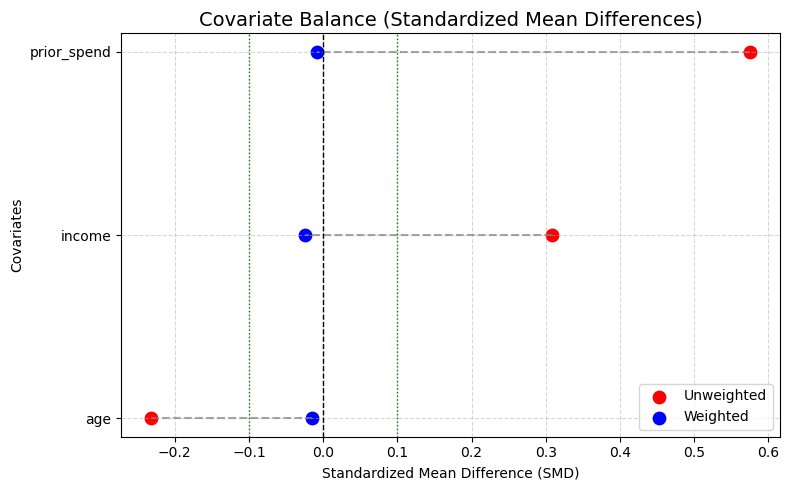

In [7]:
### Plotting the result ###
covariates = ["age", "income", "prior_spend"]
smd_unweighted = np.array([-0.232, 0.309, 0.575])
smd_weighted = np.array([-0.015, -0.024, -0.008])

# Plot
plt.figure(figsize=(8,5))

# Plot unweighted and weighted points
plt.scatter(smd_unweighted, covariates, color="red", label="Unweighted", s=80)
plt.scatter(smd_weighted, covariates, color="blue", label="Weighted", s=80)

# Add horizontal lines for each covariate
for i, cov in enumerate(covariates):
    plt.plot([smd_unweighted[i], smd_weighted[i]], [cov, cov], color="gray", linestyle="--", alpha=0.7)

# Reference line for threshold
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.axvline(x=0.1, color="green", linestyle=":", linewidth=1)
plt.axvline(x=-0.1, color="green", linestyle=":", linewidth=1)

plt.title("Covariate Balance (Standardized Mean Differences)", fontsize=14)
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Covariates")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig('images/chp4_smd.png', dpi=300);
plt.show()

In [8]:
### Nearest-Neighbor Matching for ATT ###

# Safe masks (avoid df.T)
m1 = df["T"] == 1
m0 = ~m1

# Keep only rows with finite propensity scores
finite_ps = np.isfinite(df["ps"].values)

treated = df.loc[m1 & finite_ps].copy()
control = df.loc[m0 & finite_ps].copy()

# Sanity checks
if treated.empty or control.empty:
    raise ValueError("No treated or no control units with valid (finite) propensity scores.")

# Fit NN on controls' propensity scores (2D input)
nbrs = NearestNeighbors(n_neighbors=1, algorithm="auto")
nbrs.fit(control[["ps"]].values)

# Find nearest control for each treated unit in PS space
dist, idx = nbrs.kneighbors(treated[["ps"]].values)
matched_controls = control.iloc[idx.flatten()].reset_index(drop=True)

# ATT = average difference for treated vs. their matched control
att_match = (treated["y"].reset_index(drop=True) - matched_controls["y"]).mean()

print("== Nearest-Neighbor Matching (ATT) ==")
print(f"ATT (matched on propensity score) = {att_match:,.2f}")

# Interpretation: Effect for those treated; should also be near tau if balance is good.

== Nearest-Neighbor Matching (ATT) ==
ATT (matched on propensity score) = 50.64
